In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from bayes_opt import BayesianOptimization
from hyperopt import hp
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import lightgbm as lgbm

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv', 'sample_submission.csv']


In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
trainnotreduced = pd.read_csv("../input/train.csv")

In [4]:
    trainnotreduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [5]:
train = reduce_mem_usage(pd.read_csv("../input/train.csv"))
test = reduce_mem_usage(pd.read_csv("../input/test.csv"))

Mem. usage decreased to 78.01 Mb (74.7% reduction)
Mem. usage decreased to 77.82 Mb (74.6% reduction)


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float16(200), int8(1), object(1)
memory usage: 78.0+ MB


In [7]:
train_majority = train[train.target==0]
train_minority = train[train.target==1]
 


In [8]:
train_majority.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179902 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float16(200), int8(1), object(1)
memory usage: 71.5+ MB


In [9]:
from sklearn.utils import resample
# Upsample minority class
train_minority_upsampled = resample(train_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=179902,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
train_upsampled = pd.concat([train_majority, train_minority_upsampled])
 
# Display new class counts
train_upsampled.target.value_counts()

1    179902
0    179902
Name: target, dtype: int64

In [10]:
plt.figure();

<Figure size 432x288 with 0 Axes>

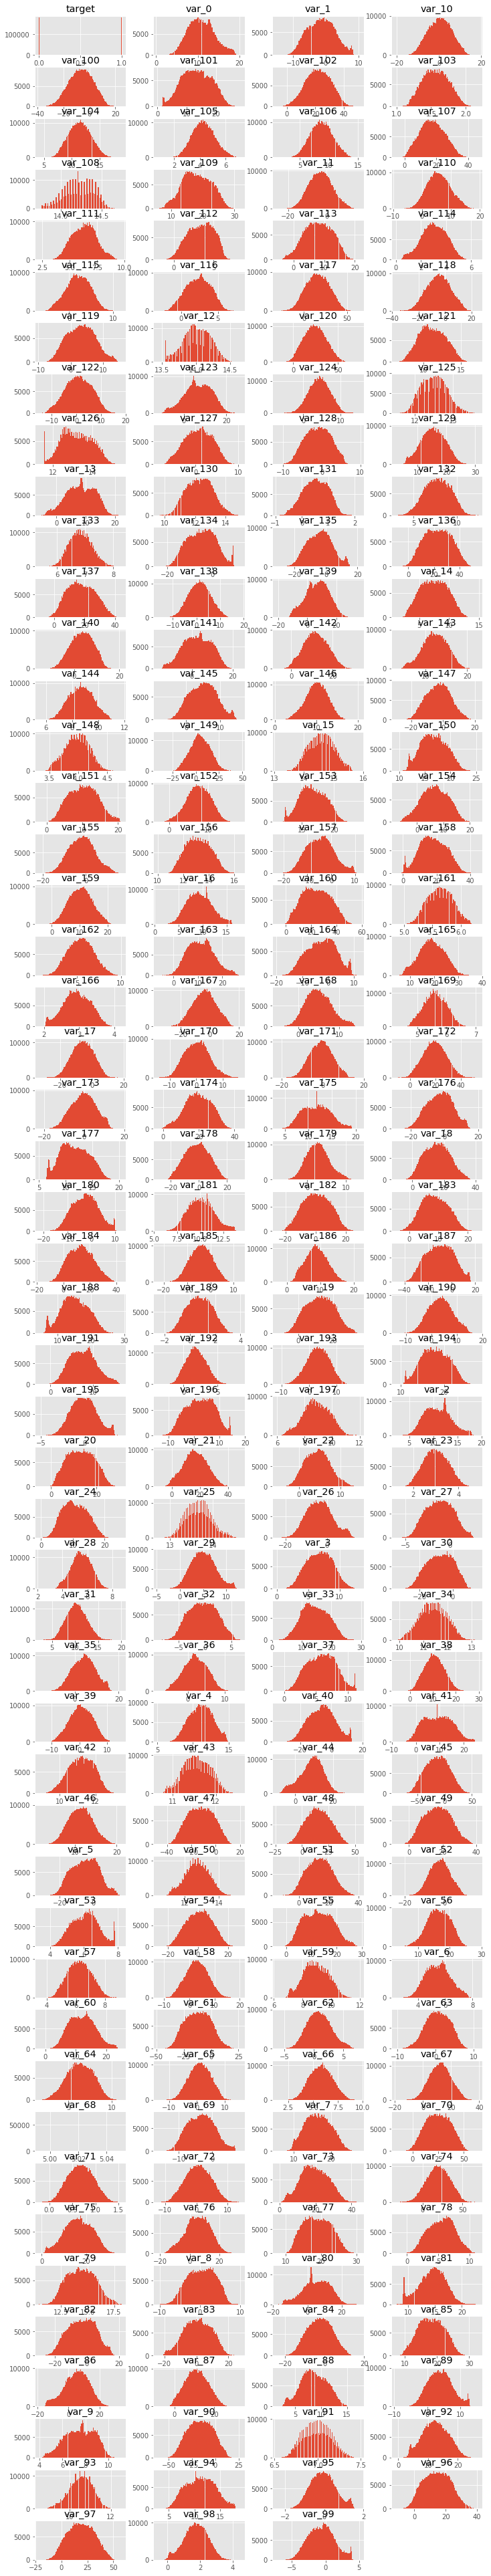

In [12]:
plt.style.use('ggplot')
columns = list(train_upsampled)[1:-2]
train_upsampled[columns].hist(stacked=False, bins=100, figsize=(12,70), layout=(50,4));

In [13]:
X = train.drop(['ID_code','target'],axis = 1)
y = train['target']

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
mms = MinMaxScaler()

In [16]:
X_mms = mms.fit_transform(X)


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float16 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [17]:
X_mms = pd.DataFrame(X_mms,columns= X.columns)


In [18]:
X_mms.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.516049,0.527862,0.498661,0.516849,0.517701,0.552014,0.502044,0.501178,0.522455,0.501067,0.536177,0.527900,0.481209,0.513128,0.468545,0.536021,0.502256,0.528148,0.494296,0.522018,0.509998,0.462536,0.483465,0.493741,0.431001,0.489672,0.505860,0.534535,0.513961,0.548974,0.537540,0.457674,0.537206,0.473119,0.465280,0.535080,0.460289,0.540389,0.469473,0.509249,...,0.481518,0.536523,0.498419,0.514271,0.533300,0.448901,0.469660,0.555766,0.505996,0.486646,0.464207,0.535872,0.480734,0.530458,0.498777,0.476717,0.533025,0.443065,0.477954,0.490447,0.554597,0.520197,0.483604,0.476214,0.496999,0.522649,0.484401,0.530473,0.440037,0.500886,0.532663,0.521882,0.469882,0.502720,0.483627,0.536921,0.507521,0.488026,0.483884,0.527402
std,0.152736,0.159313,0.153164,0.154473,0.139955,0.157857,0.142121,0.153030,0.161338,0.172069,0.139592,0.137941,0.155956,0.163711,0.161444,0.147617,0.147676,0.128088,0.149795,0.168020,0.160051,0.138650,0.142984,0.143761,0.144549,0.147379,0.148345,0.161922,0.116934,0.145900,0.157849,0.119786,0.164103,0.154160,0.156143,0.136136,0.139684,0.172383,0.118319,0.136231,...,0.165205,0.149579,0.149279,0.154341,0.169933,0.145513,0.156171,0.136210,0.154275,0.130451,0.141623,0.133099,0.133352,0.143397,0.153381,0.164167,0.152230,0.168081,0.145151,0.131402,0.151267,0.152894,0.162234,0.156950,0.148240,0.132811,0.128849,0.164107,0.158328,0.148159,0.140171,0.155757,0.120977,0.132791,0.163064,0.149906,0.167625,0.152612,0.152242,0.154996
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.404173,0.405501,0.382873,0.400228,0.414618,0.428795,0.397181,0.384750,0.396464,0.368

X_mms.var_68

In [20]:
from hyperopt import STATUS_OK
from hyperopt.pyll.base import scope

N_FOLDS = 10


train_set = lgbm.Dataset(X_mms,y)
def objective(params, n_folds = N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Tuning"""
    
    # Perform n_fold cross validation with hyperparameters
    # Use early stopping and evalute based on ROC AUC
    cv_results = lgbm.cv(params, train_set, nfold = n_folds, num_boost_round = 5000, early_stopping_rounds=1000
                        ,metric = 'auc', seed = 50)
  
    # Extract the best score
    best_score = max(cv_results['auc-mean'])
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [21]:
# Define the search space
space = {
  
    
    'num_leaves': scope.int(hp.quniform('num_leaves',10, 90, 3)),
    'learning_rate': hp.quniform('learning_rate',0, 3,0.1),
    'subsample_for_bin': scope.int( hp.quniform('subsample_for_bin', 20000, 400000, 20000)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples',20,500,5)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 5.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'colsample_bytree': hp.quniform('colsample_by_tree', 0.0, 1.0,0.01)
}

In [22]:
from hyperopt import tpe
# Algorithm
tpe_algorithm = tpe.suggest

In [23]:
from hyperopt import Trials
# Trials object to track progress
bayes_trials = Trials()

In [25]:
from hyperopt import fmin

MAX_EVALS = 10

# Optimize
best = fmin(fn = objective, space = space, algo = tpe.suggest,max_evals = MAX_EVALS, trials = bayes_trials)

100%|██████████| 1/1 [20:33<00:00, 1233.70s/it, best loss: 0.11295228122906609]


In [26]:
best


{'colsample_by_tree': 0.9400000000000001,
 'learning_rate': 0.1,
 'min_child_samples': 335.0,
 'num_leaves': 27.0,
 'reg_alpha': 2.4376113452795822,
 'reg_lambda': 4.942768696457326,
 'subsample_for_bin': 240000.0}

In [34]:
best = {'colsample_by_tree': 0.9400000000000001,
 'learning_rate': 0.1,
 'min_child_samples': 335,
 'num_leaves': 27,
 'reg_alpha': 2.4376113452795822,
 'reg_lambda': 4.942768696457326,
 'subsample_for_bin': 240000}

In [38]:
lgbtrain = lgbm.train(best,train_set=train_set,num_boost_round=5000)

In [39]:
testdata = pd.read_csv("../input/test.csv")

In [45]:
test = testdata.drop(['ID_code'],axis=1)

In [46]:
testMMs = mms.fit_transform(test)

In [49]:
Test_mms = pd.DataFrame(testMMs,columns= test.columns)

In [50]:
Test_mms.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.473015,0.549324,0.510563,0.517351,0.529912,0.504578,0.525585,0.479002,0.521527,0.492006,0.537314,0.529394,0.475675,0.504136,0.488330,0.528137,0.528155,0.482803,0.529120,0.522651,0.459028,0.473708,0.492696,0.448296,0.459844,0.496735,0.540959,0.521808,0.478541,0.544973,0.544254,0.500791,0.506918,0.474358,0.480894,0.529888,0.538184,0.524042,0.492637,0.522331,...,0.451698,0.505687,0.520894,0.514982,0.558591,0.469237,0.478432,0.571695,0.506935,0.507473,0.480041,0.520101,0.484125,0.509521,0.502823,0.512633,0.546539,0.456482,0.493544,0.474012,0.516969,0.543614,0.510119,0.458869,0.484412,0.529356,0.470036,0.522241,0.447209,0.519275,0.501652,0.515872,0.464207,0.507308,0.464000,0.505244,0.543618,0.449187,0.465320,0.537540
std,0.137193,0.165401,0.161006,0.155930,0.153179,0.174793,0.142076,0.151666,0.169884,0.182221,0.128446,0.139996,0.151150,0.175687,0.160485,0.158634,0.149220,0.140382,0.156149,0.165999,0.169524,0.142958,0.148075,0.145281,0.153476,0.154567,0.156501,0.161999,0.139854,0.150223,0.164545,0.118723,0.170774,0.156977,0.156882,0.131762,0.132452,0.174979,0.131058,0.144370,...,0.148548,0.152073,0.141362,0.158492,0.163414,0.151061,0.154246,0.135655,0.151376,0.138285,0.136187,0.142806,0.133051,0.147545,0.157853,0.170286,0.152618,0.175308,0.150158,0.128413,0.151021,0.157240,0.159046,0.143805,0.151803,0.135161,0.133589,0.163134,0.160664,0.155142,0.132103,0.158192,0.130441,0.137562,0.169171,0.151172,0.182366,0.150815,0.150780,0.154361
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.372911,0.423410,0.390026,0.399023,0.417587,0.367955,0.420006,0.364062,0.389985,0.352

In [52]:
testY = lgbtrain.predict(Test_mms)

In [62]:
submission = pd.DataFrame({
        "ID_code": testdata["ID_code"],
        "target": testY
    })
submission.to_csv('submission.csv', index=False)